In [ ]:
from pathlib import Path
import decoupler as dc
import numpy as np
import plotnine as pn
import scanpy as sc
import pandas as pd
import partipy as pt
from partipy.datasets import load_hepatocyte_data_2

data_dir = Path("..") / "data"
adata = load_hepatocyte_data_2(data_dir=data_dir)
adata

AnnData object with n_obs × n_vars = 1999 × 8354
    obs: 'cell_type', 'zone', 'run_id', 'time_point', 'UMAP_X', 'UMAP_Y'

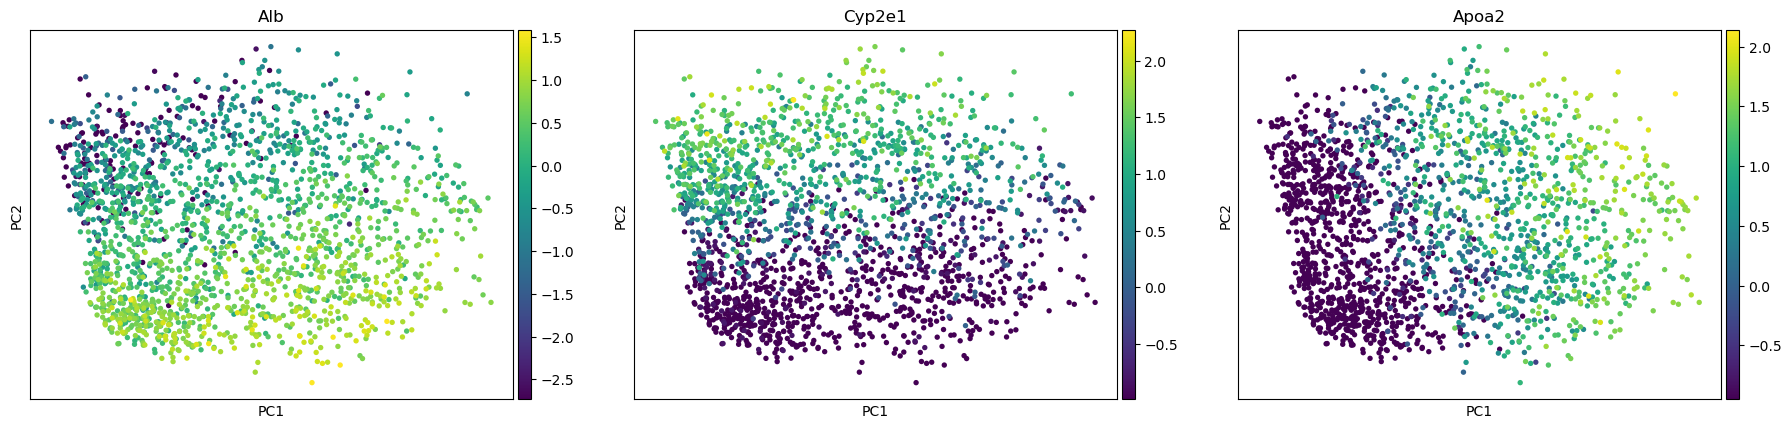

In [2]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable")
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10)
sc.pl.pca_scatter(adata, color=["Alb", "Cyp2e1", "Apoa2"])

100%|██████████| 50/50 [05:06<00:00,  6.13s/it]


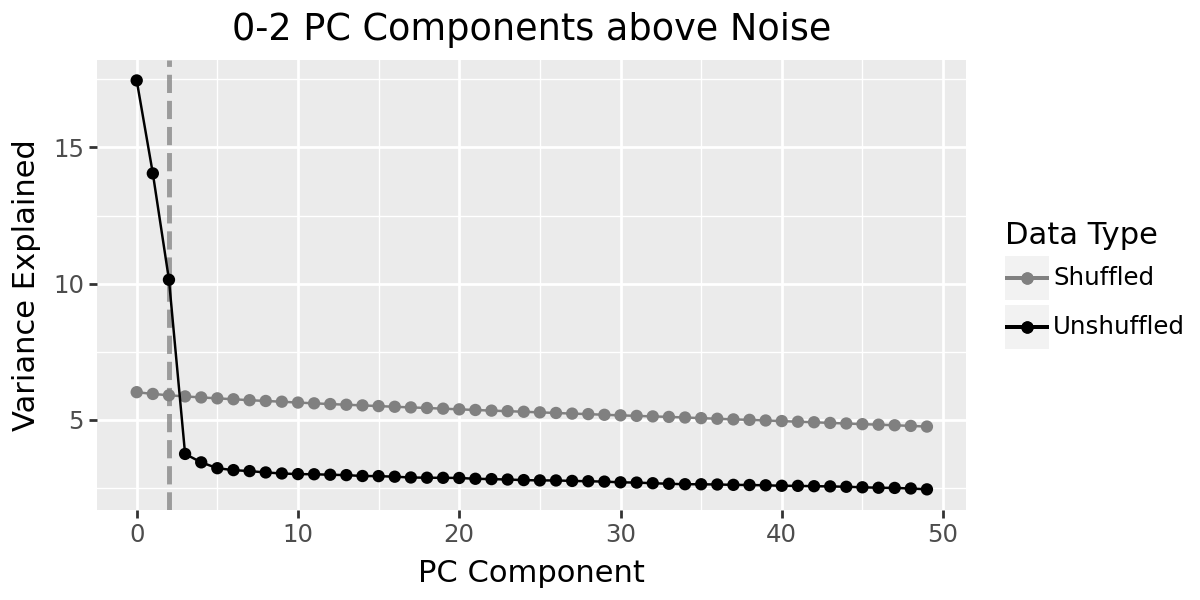

In [3]:
pt.compute_shuffled_pca(adata, mask_var="highly_variable")
pt.plot_shuffled_pca(adata)

In [4]:
pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimensions=3)

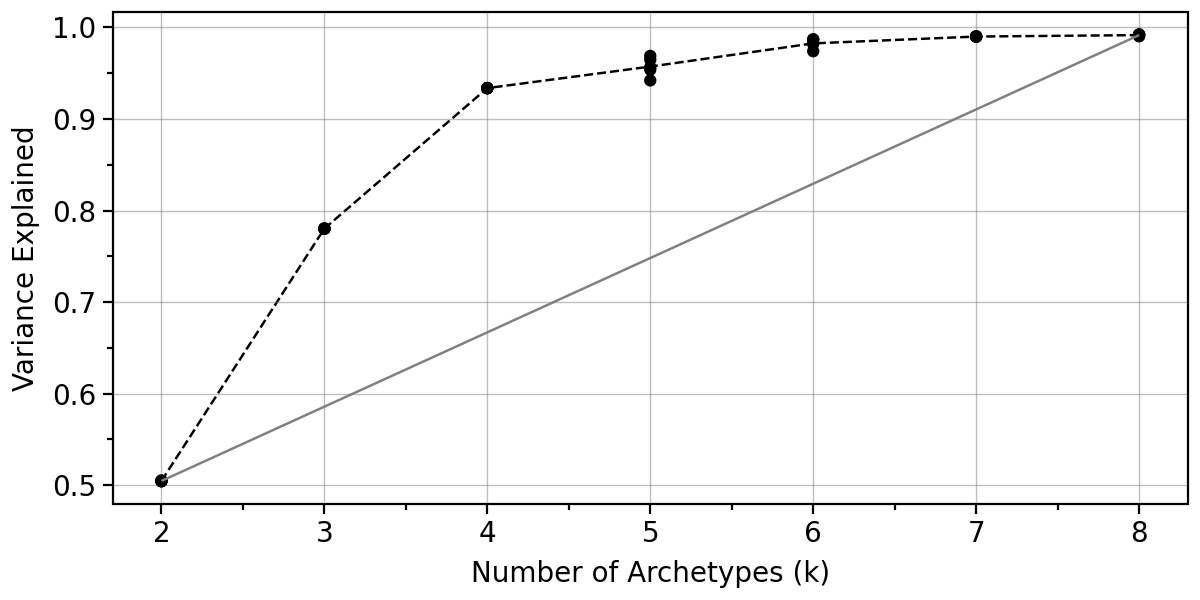

In [5]:
pt.compute_selection_metrics(adata=adata, min_k=2, max_k=8)
pt.plot_var_explained(adata)

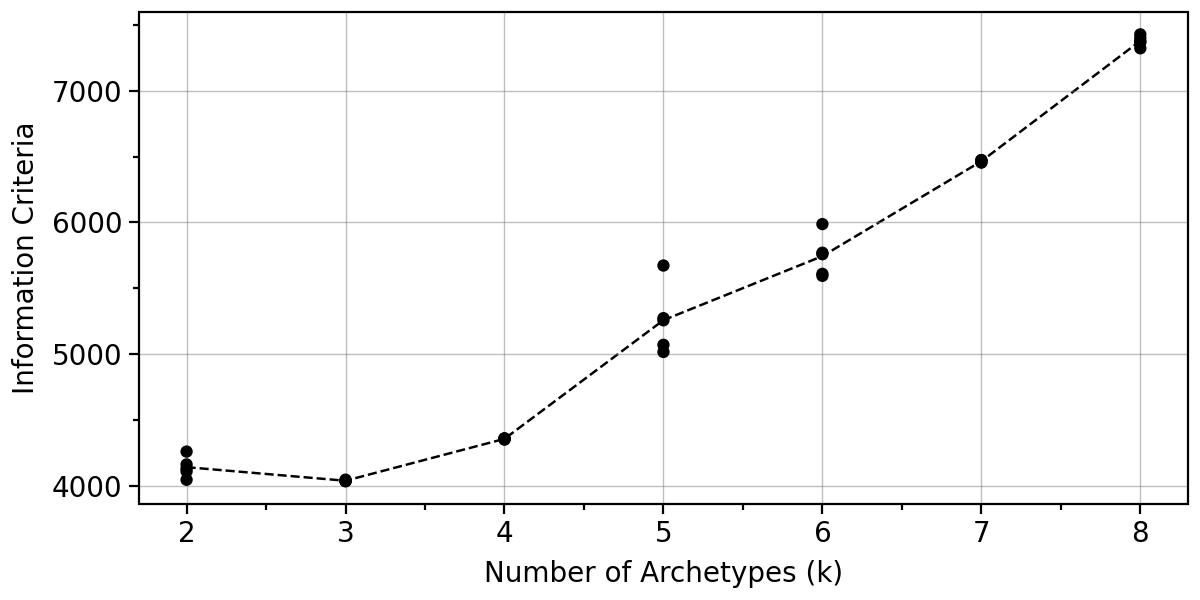

In [6]:
pt.plot_IC(adata)

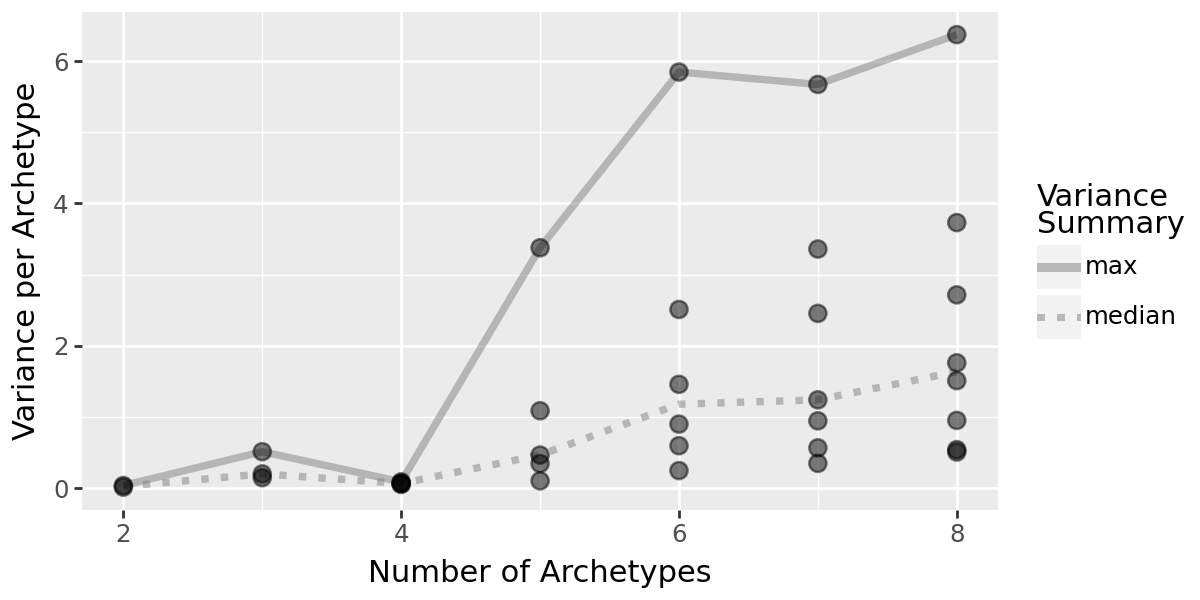

In [7]:
pt.compute_bootstrap_variance(adata=adata, n_bootstrap=50, n_archetypes_list=range(2, 9))
pt.plot_bootstrap_variance(adata)

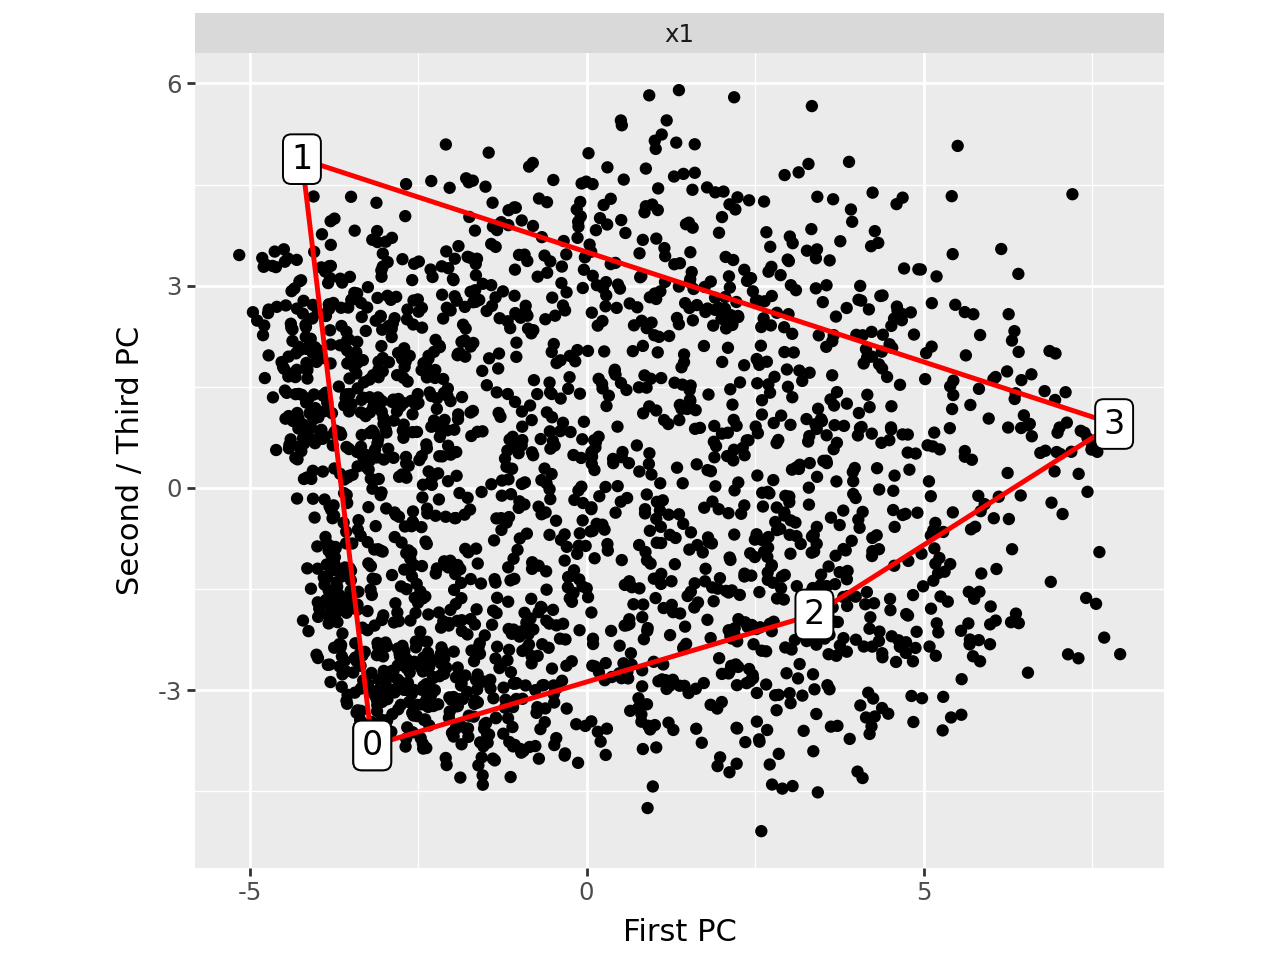

In [8]:
pt.compute_archetypes(adata, n_archetypes=4, archetypes_only=False)
    
pt.plot_archetypes_2D(adata=adata)

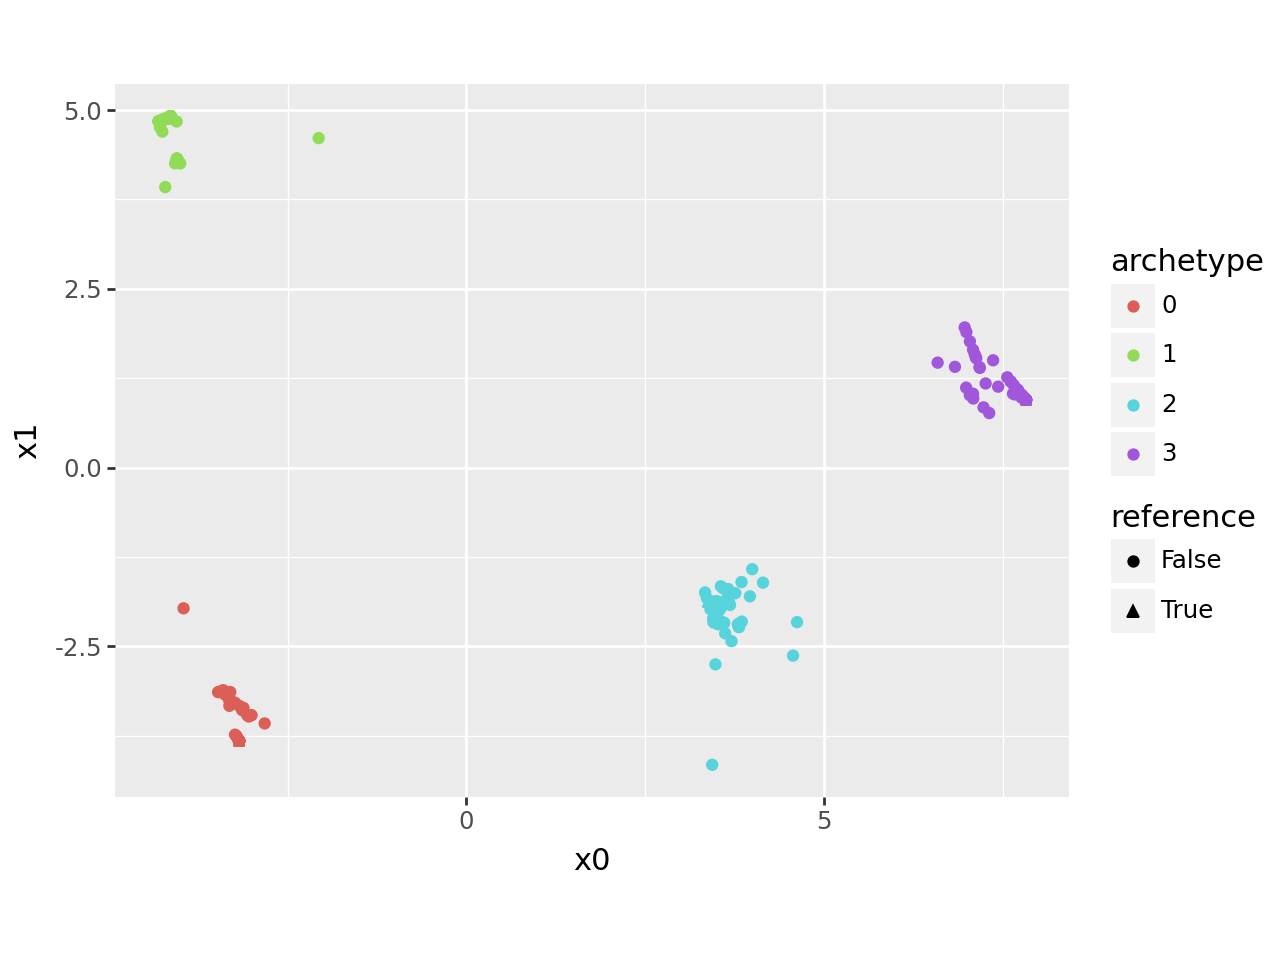

In [9]:
pt.plot_bootstrap_2D(adata, n_archetypes=4)

In [12]:
pt.compute_archetype_weights(adata=adata, mode="automatic")
archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")

Applied length scale is 3.25.


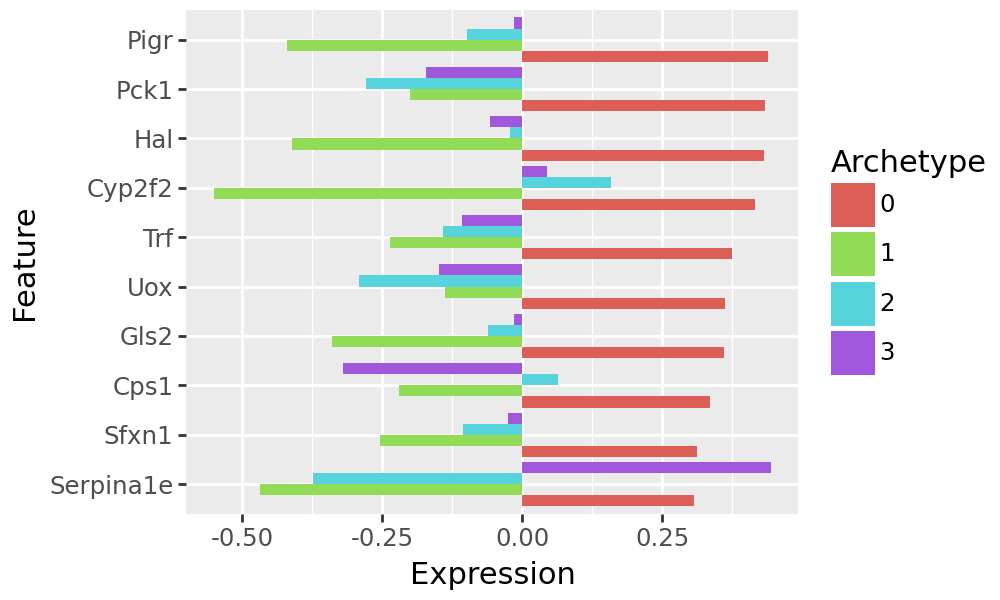

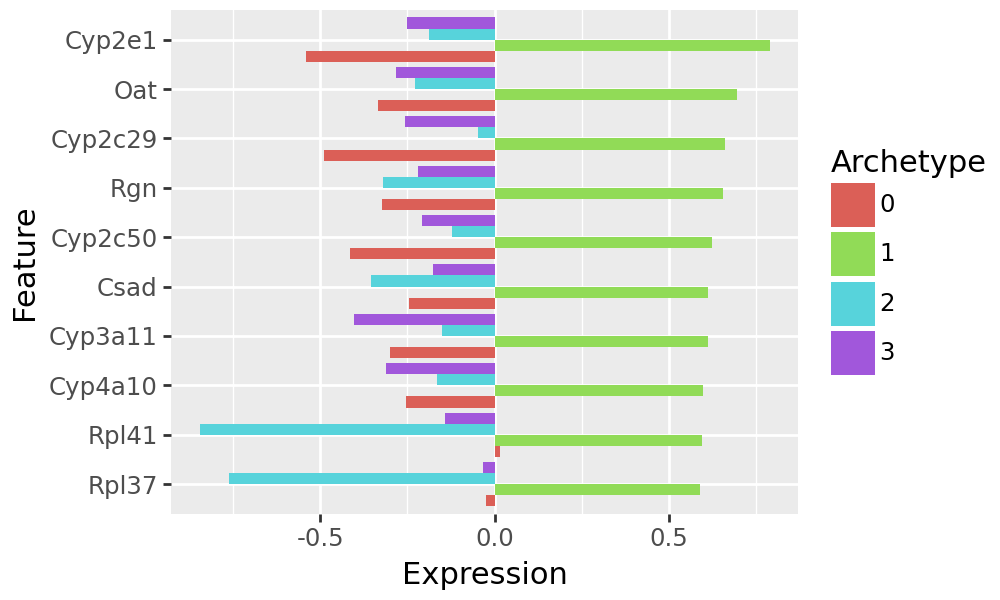

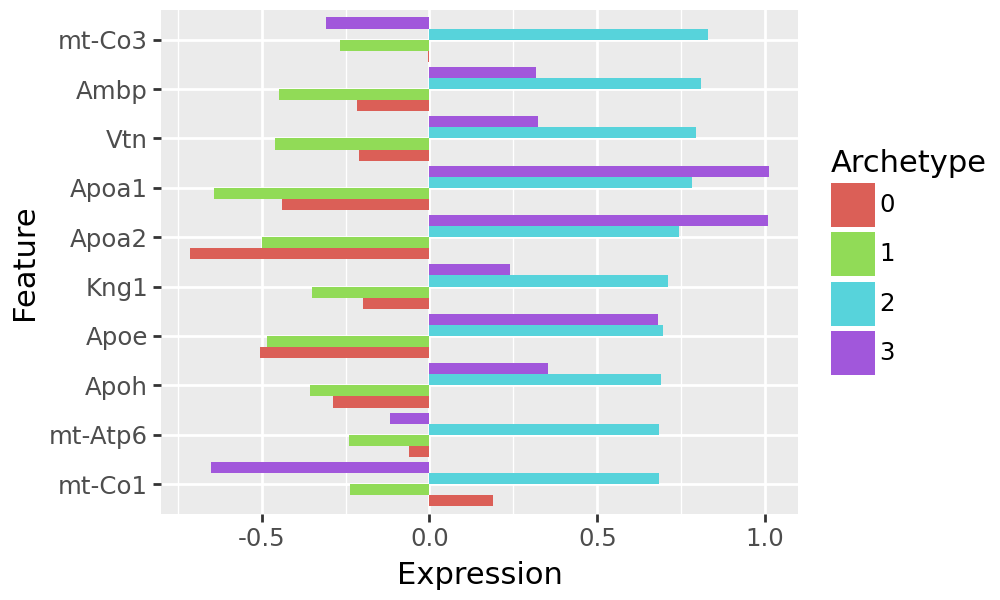

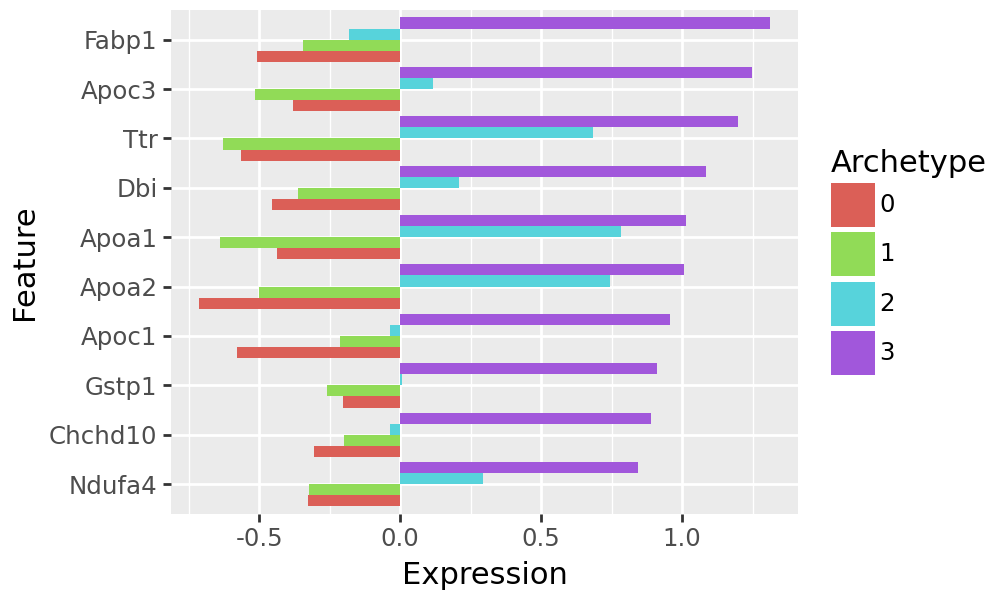

In [13]:
for arch_idx in range(adata.uns["AA_results"]["Z"].shape[0]):
    p = pt.plot_top_genes(archetype_expression=archetype_expression, arch_idx=arch_idx, top_n=10) + pn.theme(figure_size=(5, 3))
    p.show()

In [14]:
database = "reactome_pathways"
min_genes_per_pathway = 5
max_genes_per_pathway = 80

msigdb_raw = dc.op.resource("MSigDB")
msigdb = msigdb_raw[msigdb_raw["collection"]==database]
selection_vec = ~ np.array(["RESPONSE_TO" in s for s in msigdb["geneset"]]) & \
    ~ np.array(["GENE_EXPRESSION" in s for s in msigdb["geneset"]]) & \
    ~ np.array(["SARS_COV" in s for s in msigdb["geneset"]]) & \
    ~ np.array(["STIMULATED_TRANSCRIPTION" in s for s in msigdb["geneset"]])
msigdb = msigdb.loc[selection_vec, :].copy()
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])].copy()
genesets_within_min = (msigdb.value_counts("geneset") >= min_genes_per_pathway).reset_index().query("count")["geneset"].to_list()
genesets_within_max = (msigdb.value_counts("geneset") <= max_genes_per_pathway).reset_index().query("count")["geneset"].to_list()
genesets_to_keep = list(set(genesets_within_min) & set(genesets_within_max))
msigdb = msigdb.loc[msigdb["geneset"].isin(genesets_to_keep), :].copy() # removing small gene sets
msigdb_mouse = dc.op.translate(msigdb, target_organism="mouse") # requires decoupler >= 2.0.0
msigdb_mouse = msigdb_mouse.drop_duplicates()
msigdb_mouse = msigdb_mouse.rename(columns={"geneset": "source", "genesymbol": "target"})

acts_ulm_est, acts_ulm_est_p = dc.mt.ulm(data=archetype_expression,
                                         net=msigdb_mouse,
                                         verbose=False)

acts_ulm_est.iloc[:4, :4]

,REACTOME_2_LTR_CIRCLE_FORMATION,REACTOME_ABACAVIR_ADME,REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS
0,-0.524164,0.378347,-1.795653,-0.126100
1,0.362084,0.373948,-1.290251,-0.051556
2,0.662086,-0.631647,2.725753,0.154484
3,0.035521,-1.131540,1.442886,0.192030


In [15]:
top_processes = pt.extract_enriched_processes(est=acts_ulm_est, 
                                              pval=acts_ulm_est_p, 
                                              order="desc", 
                                              n=10,
                                              p_threshold=0.10)

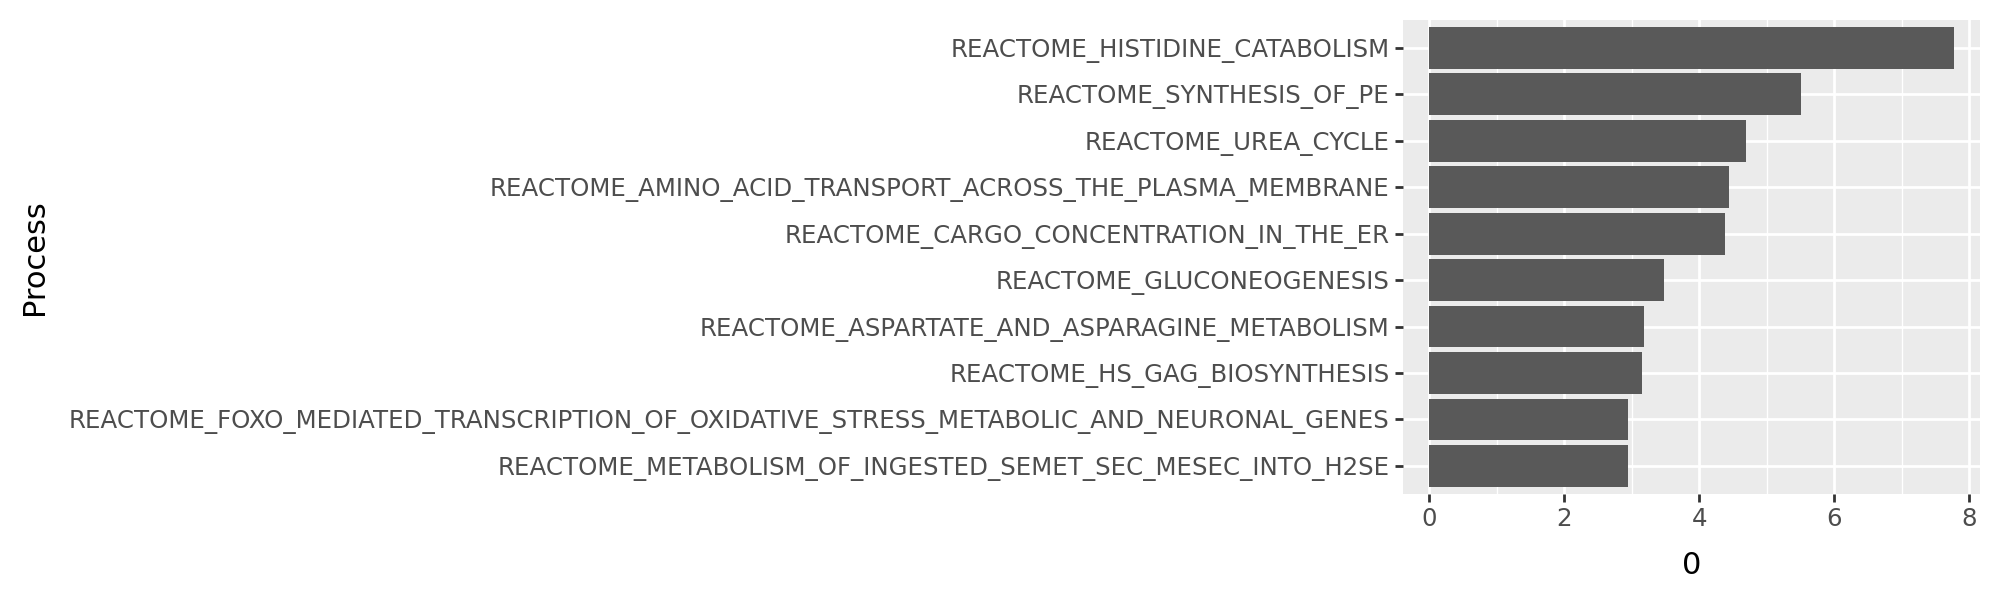

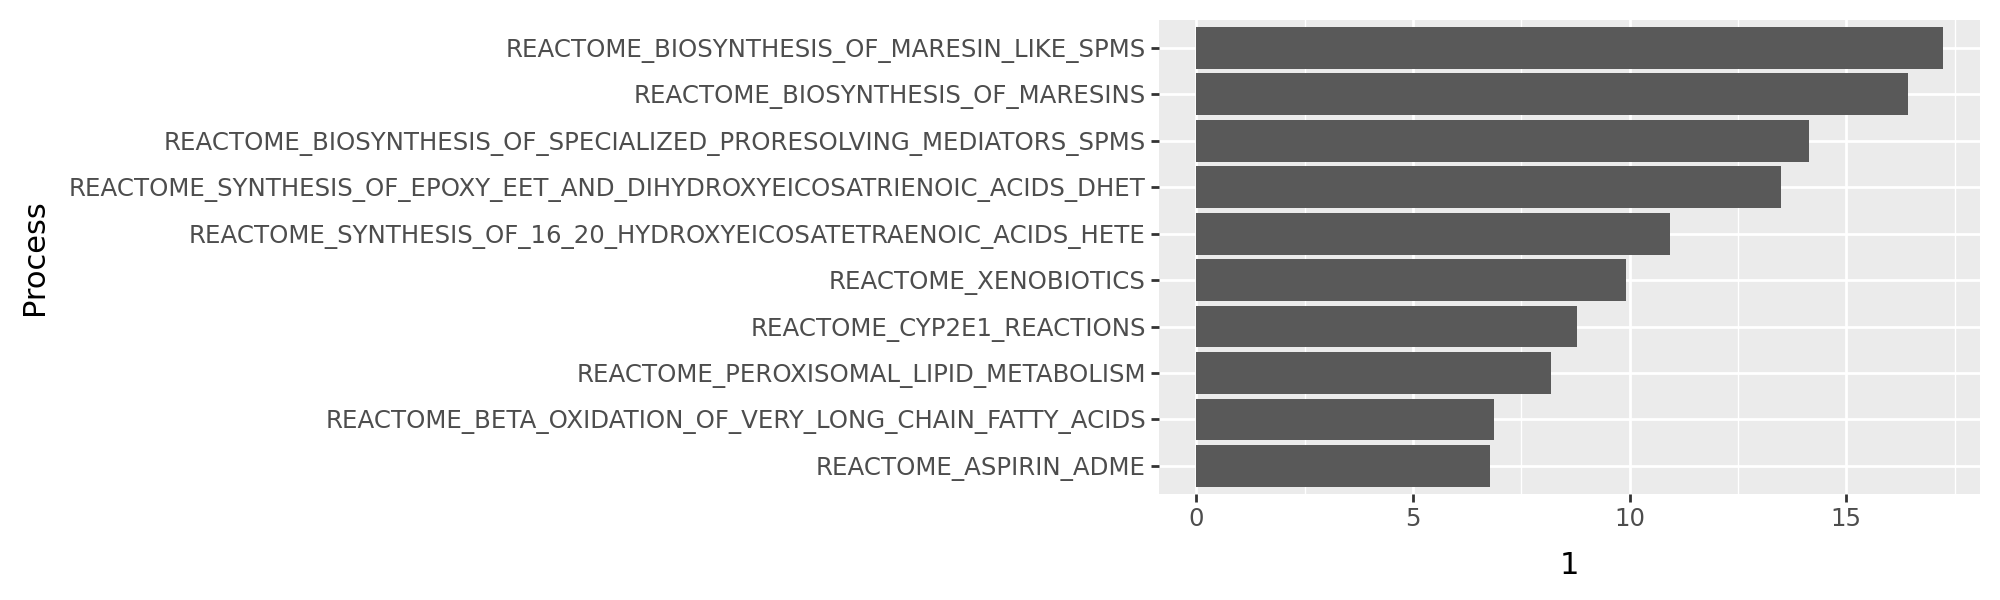

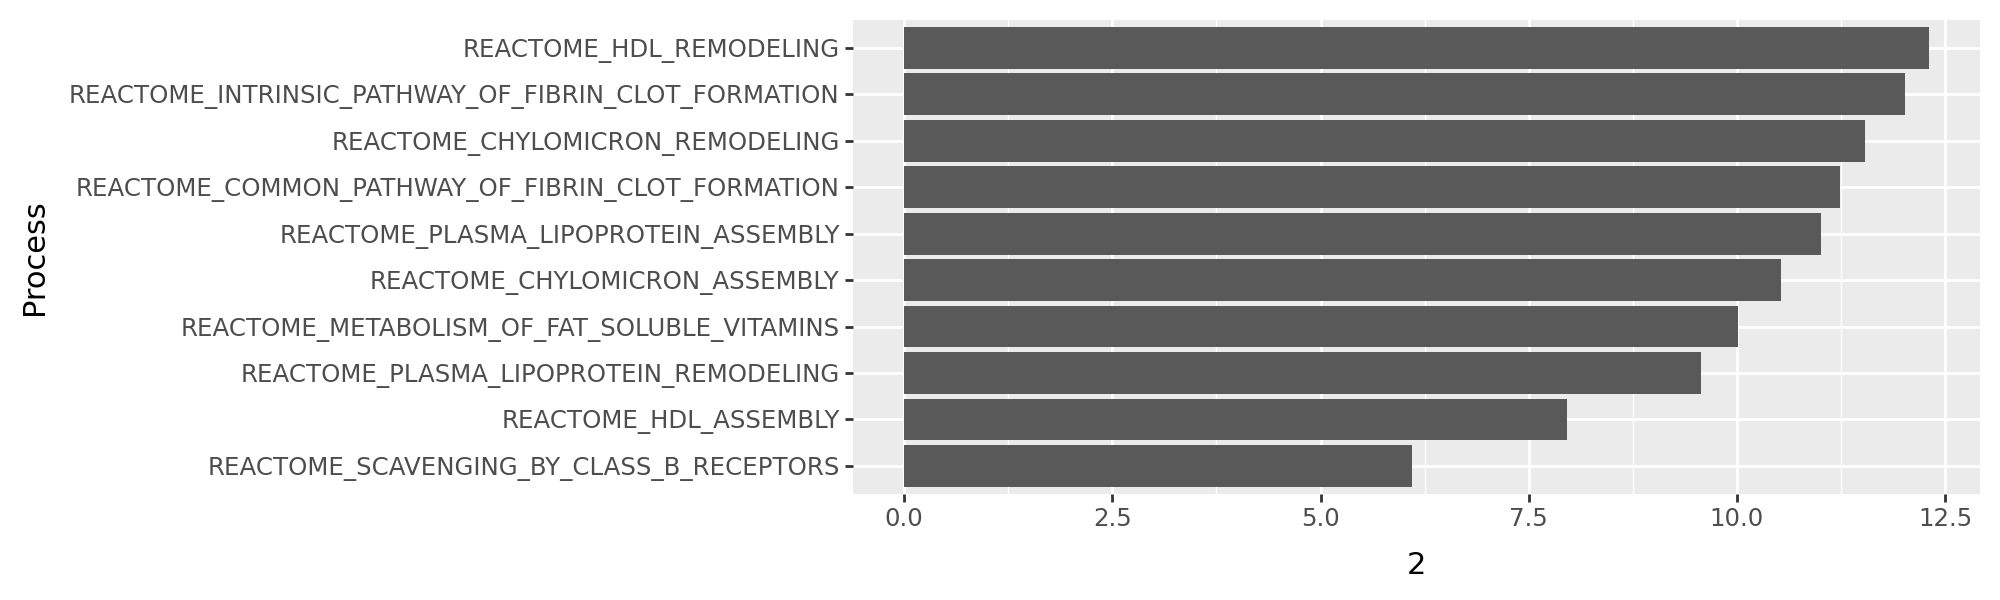

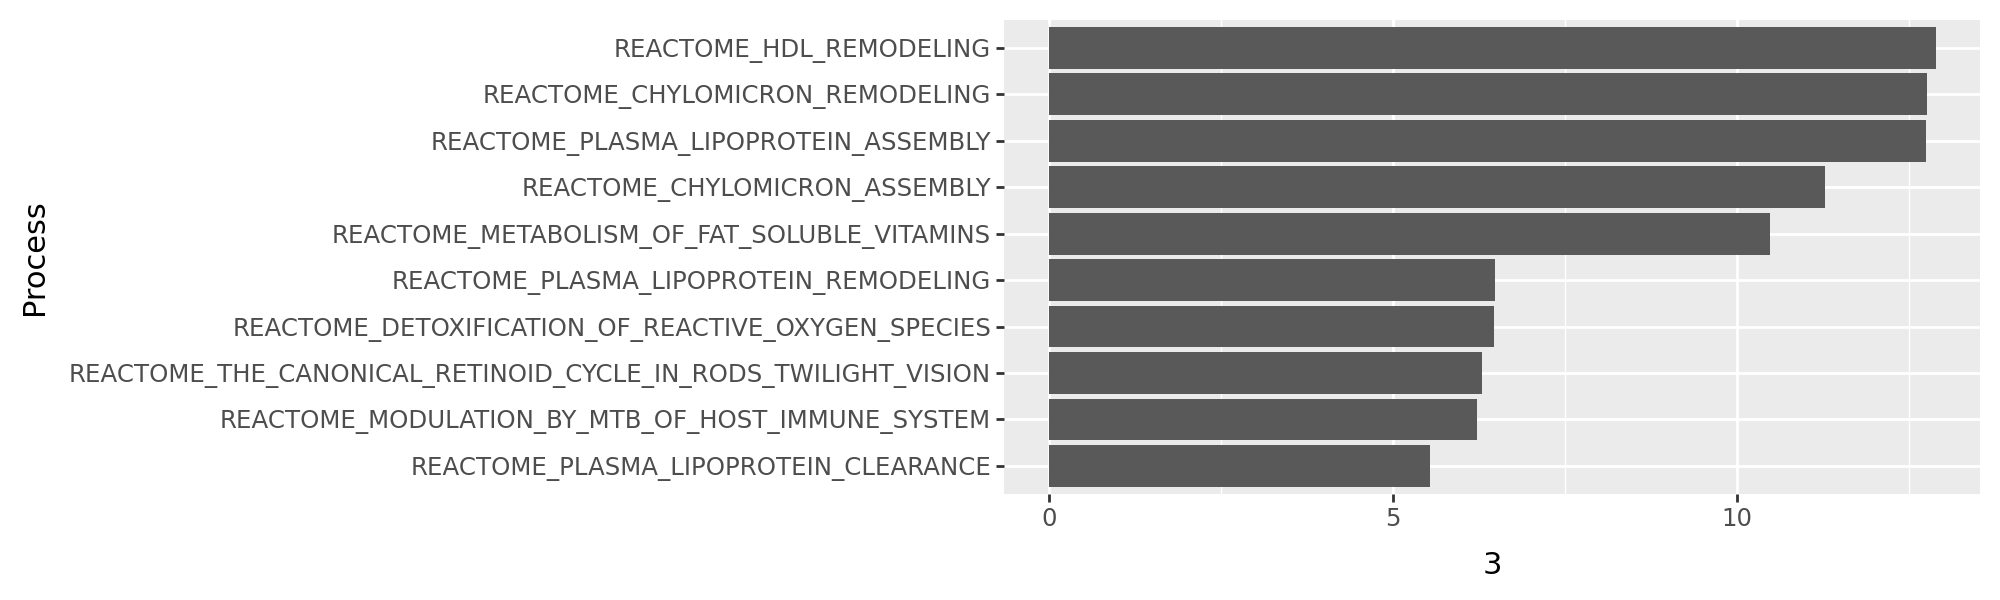

In [16]:
for arch_idx in range(adata.uns["AA_results"]["Z"].shape[0]):
    top_processes[arch_idx]["Process"] = pd.Categorical(
        top_processes[arch_idx]["Process"],
        categories=top_processes[arch_idx].sort_values(f"{arch_idx}", ascending=True)["Process"].to_list()
    )

    p = (pn.ggplot(top_processes[arch_idx])
        + pn.geom_col(pn.aes(x="Process", y=f"{arch_idx}"))
        + pn.coord_flip()
        + pn.theme(figure_size=(10, 3))
        )
    p.show()

In [17]:
import session_info2
print(session_info2.session_info(dependencies=True))

pandas	2.2.3
plotnine	0.14.5
decoupler	2.0.2
numpy	2.1.3
scanpy	1.11.1
partipy	0.0.1
anndata	0.11.4
----	----
cycler	0.12.1
packaging	25.0
url-normalize	2.2.1
zstandard	0.23.0
dask	2024.11.2
requests	2.32.3
natsort	8.4.0
stack_data	0.6.3
typing_extensions	4.14.0
pure_eval	0.2.3
threadpoolctl	3.6.0
joblib	1.5.1
Pygments	2.19.1
prompt_toolkit	3.0.51
attrs	25.3.0
seaborn	0.13.2
ipython	9.3.0
asciitree	0.3.3
urllib3	2.4.0
session-info2	0.1.2
jedi	0.19.2
legendkit	0.3.6
matplotlib-inline	0.1.7
requests-cache	1.2.1
h5py	3.14.0
python-dateutil	2.9.0.post0
kiwisolver	1.4.7
PySocks	1.7.1
wcwidth	0.2.13
traitlets	5.14.3
legacy-api-wrap	1.4.1
mizani	0.13.5
comm	0.2.2
certifi	2025.4.26 (2025.04.26)
pytz	2025.2
six	1.17.0
pyarrow	20.0.0
zarr	2.18.7
pycparser	2.22
future	1.0.0
psutil	7.0.0
PyYAML	6.0.2
matplotlib	3.10.1
jupyter_client	8.6.3
statsmodels	0.14.4
numba	0.61.0
debugpy	1.8.14
pyzmq	26.4.0
charset-normalizer	3.4.2
decorator	5.2.1
scikit-learn	1.5.2
pillow	11.2.1
Deprecated	1.2.18
idna	3.10